### Tantus competition - Authorship comparison

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from sentence_transformers import SentenceTransformer, util

from sklearn.metrics import pairwise_distances

import os
import random
import tqdm

from itertools import combinations
from Levenshtein import distance

In [2]:
import torch

if torch.cuda.is_available():
    print("CUDA is available.")
else:
    print("CUDA is not available.")

CUDA is available.


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 70)
# Set the maximum column width to a larger value (e.g., 100 characters)
pd.set_option('display.max_colwidth', 100)

np.set_printoptions(suppress=True)

# Supress Warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
DATA_DIR = Path('/home/kcini75/Notebooks/Tantus competition')
SEED = 553

# Set seed for Python's random module
random.seed(SEED)

# Set seed for NumPy
np.random.seed(SEED)

# Set seed for PyTorch (both CPU and CUDA)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
# Loading datasets

train_df_full = pd.read_csv(DATA_DIR / 'train.csv')
test_df = pd.read_csv(DATA_DIR / 'test.csv')
test_texts_df = pd.read_csv(DATA_DIR / 'test_texts.csv')
sample_submission_df = pd.read_csv(DATA_DIR / 'sample_submission.csv')

In [7]:
# Checking if there are duplicates within the author sets

# Create a copy of the original DataFrame to store results
filtered_df = train_df_full.copy()

for auth in train_df_full.author.unique():
    temp_df = train_df_full[train_df_full.author == auth]
    
    # Column for storing distances
    distance_results = []

    # Get the column data
    column_data = temp_df['content'].tolist()

    # Calculate Levenshtein distance for all combinations
    for pair in combinations(column_data, 2):
        str1, str2 = pair
        dist = distance(str1, str2)
        if dist < 50:
            distance_results.append((str1, str2, dist))
            
            # Keep track of strings that need to be removed
            filtered_df = filtered_df[(filtered_df['author'] != auth) | (filtered_df['content'] != str1)]

    # Create a DataFrame from the results
    distance_df = pd.DataFrame(distance_results, columns=['text1', 'text2', 'levenshtein_distance'])

    # Print the resulting DataFrame
    if distance_results:
        print(f'Levensthein distance for Author {auth}')
        print('---------------------------------------')
        print(str(distance_df))
        print()
    
    

Levensthein distance for Author 26

---------------------------------------

                                                                                                 text1  \

0  Czech Prime Minister Vaclav Klaus announced a state commission on Wednesday to attack bureaucrac...   

1  The Czech Statistical Bureau (CSU) said on Thursday it would change its methodology for calculat...   



                                                                                                 text2  \

0  Czech Prime Minister Vaclav Klaus announced a state commission on Wednesday to attack bureaucrac...   

1  The Czech Statistical Bureau\n(CSU) said on Thursday it would change its methodology for\ncalcul...   



   levenshtein_distance  

0                    42  

1                    40  



Levensthein distance for Author 20

---------------------------------------

                                                                                                 text1  \

0  The Int

The above shows that Authors 26, 20, 21, 15 and 18 have multiple similar entries. The filtered_df dataframe will only contain those strings that are not duplicated. 

In [8]:
train_df_full = filtered_df.reset_index(drop=True)

### Correcting the dataset

In [9]:
# Removing one of the duplicated authors
# 19 and 1 are duplicated
# 8,9 and 10 are duplicated
# 13 and 14 are duplicated

train_df_full = train_df_full.drop(train_df_full[train_df_full.author==19].index)
train_df_full = train_df_full.drop(train_df_full[train_df_full.author==9].index)
train_df_full = train_df_full.drop(train_df_full[train_df_full.author==10].index)
train_df_full = train_df_full.drop(train_df_full[train_df_full.author==14].index)

In [10]:
train_df_full.reset_index(inplace=True, drop=True)

In [11]:
author_sorted = np.sort(train_df_full.author.unique())

In [12]:
# Creating a mapping so that authors(labels) are in ascending order due to compute metrics in the training phase
# Create a mapping dictionary

mapping_dict = {}
new_value = 0
for original_value in sorted(author_sorted):
    mapping_dict[original_value] = new_value
    new_value += 1

# Print the mapping dictionary
print(mapping_dict)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 11: 9, 12: 10, 13: 11, 15: 12, 16: 13, 17: 14, 18: 15, 20: 16, 21: 17, 22: 18, 23: 19, 24: 20, 25: 21, 26: 22, 27: 23, 28: 24, 29: 25, 30: 26, 31: 27, 32: 28, 33: 29, 34: 30, 35: 31, 36: 32, 37: 33, 38: 34, 39: 35, 40: 36, 41: 37}


In [13]:
train_df_full.author = train_df_full.author.map(mapping_dict)

In [14]:
np.sort(train_df_full.author.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37])

### Text preprocessing

In [15]:
import re

# Used gensim library for preprocessing
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_numeric

In [16]:
def preprocess_text(text):
       
    # Lowercase the text
    text = text.lower()
        
    # Handle contractions
    contractions = {
    "don't": "do not",
    "can't": "cannot",
    "won't": "will not",
    "isn't": "is not",
    "aren't": "are not",
    "haven't": "have not",
    "hasn't": "has not",
    "didn't": "did not",
    "doesn't": "does not",
    "wouldn't": "would not",
    "couldn't": "could not",
    "shouldn't": "should not",
    "wasn't": "was not",
    "weren't": "were not",
    "mightn't": "might not",
    "mustn't": "must not",
    "shan't": "shall not",
    "it's": "it is",
    "he's": "he is",
    "she's": "she is",
    "that's": "that is",
    "there's": "there is",
    "what's": "what is",
    "who's": "who is",
    "let's": "let us",
    "you're": "you are",
    "we're": "we are",
    "they're": "they are",
    "I'm": "I am",
    "I've": "I have",
    "I'll": "I will",
    # Add more contractions here
}
    
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
            
    # Remove punctuation
    text = re.sub(r'[^\w\s.]', ' ', text)
    
    # Remove stopwords
    text = remove_stopwords(text)
    
    # Remove numbers
    text = strip_numeric(text)
    
    # Remove extra white spaces and full stops
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'\.', ' ', text)  # Replace dots with white space

        
    # Remove newline characters
    text = text.replace('\n', ' ')
    
    # Strip white space
    text = text.strip()
    
    
    return text

In [17]:
train_df_full['content'] = train_df_full.content.apply(preprocess_text)

In [18]:
train_df_full.head()

,author,content
0,8,future man fonz feed reader google look boa rss feed ll look like email program open somesuch
1,33,carnival corp shopping europe acquisitions partners boost number passengers cruise ships industr...
2,20,smiths industries plc said wednesday million acquisition leland electrosystems u s offered perf...
3,24,british private client stockbroker fund manager capel cure myers capital management said thursda...
4,25,international specialty chemicals group btp plc said wednesday expected profit margins key adhes...


### Checking embedding lengths

In [ ]:
from transformers import AutoTokenizer, AutoConfig

In this section I have checked whether the tokenized text exceeds the max length for embeddings for the selected model. Following text preprocessing none of the training text content exceeded the maximum length. 

In [ ]:
model_name = 'intfloat/e5-small-v2' 

# Load the tokenizer and configuration
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)
max_seq_length = config.max_position_embeddings

for i in range(len(train_df_full)):

    author = train_df_full.author.loc[i]
    text = train_df_full.content.loc[i]
    
    # Tokenize the text
    tokens = tokenizer.encode(text, add_special_tokens=True)

    # Check if the token count exceeds the maximum sequence length
    
    token_count = len(tokens)

    if token_count > max_seq_length:
        print(f'{author} : {text}')
    

### Create train / evaluation sets

In [19]:
EVAL_SIZE = 0.2

train_df, eval_df = train_test_split(train_df_full, test_size=EVAL_SIZE, stratify=train_df_full['author'], random_state = SEED)#
train_df.reset_index(drop=True, inplace=True)
eval_df.reset_index(drop=True, inplace=True)

print(len(train_df)) 
print(len(eval_df))

292

74


### Create model

In [20]:
from sentence_transformers import SentenceTransformer, models

In [21]:
CHOSEN_MODEL = 'intfloat/e5-small-v2'

In [22]:
model1 = SentenceTransformer(CHOSEN_MODEL, device=device)

2023-09-14 16:15:34.732679: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

2023-09-14 16:15:34.763624: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.

To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

2023-09-14 16:15:35.244512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Create training and evaluation pairs

In [23]:
from collections import namedtuple
from typing import List, Set

In [25]:
TrainPair = namedtuple('TrainPair', ['content1', 'content2', 'label'])

def create_train_pairs(
    df: pd.DataFrame
    
) -> List[TrainPair]:
    
    # To make sure we do not have mirror pairs such as (a, b, 1) (b, a, 1)
    # pairs will contain desired pairs and _pairs will contain both desired and mirrored ones
    pairs: List[TrainPair] = []
    _pairs: Set[TrainPair] = set()
        
    authors = df['author'].unique()
    
    for author in authors:
        
        n_positive_pairs_per_author = len(df[df['author']==author])-1
        n_negative_pairs_per_author = len(df[df['author']==author])-1
        
        
        
        positive_count = 0
        while positive_count < n_positive_pairs_per_author:
            content1, content2 = df[df['author'] == author].sample(2)['content'].values.tolist()
            
            if content1 != content2:
            
                pair = TrainPair(content1, content2, 1)
                _pair = TrainPair(content2, content1, 1)

                if pair in _pairs:
                    continue
                else:
                    pairs.append(pair)
                    _pairs.add(pair)
                    _pairs.add(_pair)
                    positive_count += 1
                
        negative_count = 0
        while negative_count < n_negative_pairs_per_author:
            content1 = df[df['author'] == author].sample(1)['content'].values[0]
            content2 = df[df['author'] != author].sample(1)['content'].values[0]
            
                        
            if content1 != content2:
            

                pair = TrainPair(content1, content2, 0)
                _pair = TrainPair(content2, content1, 0)

                if pair in _pairs:
                    continue
                else:
                    pairs.append(pair)
                    _pairs.add(pair)
                    _pairs.add(_pair)
                    negative_count += 1
    
    return list(pairs)

In [26]:
train_pairs = create_train_pairs(train_df)
eval_pairs = create_train_pairs(eval_df)

In [27]:
# Creating a full train pairs dataset
full_pairs = create_train_pairs(train_df_full)
len(full_pairs)

656

#### Cosine Similarities for matching authors

In the below code I perform some EDA to assess the cosine similarity values between vectors for sentences coming from the same authors and sentences coming from different authors. The process is not required for the prediction part of my code and the computations take some time to compile, especially without a GPU. On average, ignoring duplicates, for matching authors, considering that we have 37 distinct authors, each with roughly 10 pieces of text each, there would be ${10 \choose 2}$ * 37 = 1665 combinations. While for non-matching authors, ignoring duplicates, this would increase to 68,265. It is hence being reproduced for analysis purposes only. 

In [ ]:
# Group the DataFrame by 'author'
grouped = train_df_full.groupby('author')

# Initialize an empty list to store pairs
matching_pairs = []

# Iterate through each author group
for _, group in grouped:
    # Get the content values for the current author group
    content_values = group['content'].tolist()

    # Create pairs of content values using combinations
    content_pairs = list(combinations(content_values, 2))

    # Append the pairs to the list
    matching_pairs.extend(content_pairs)

In [ ]:
# Create a new list to store modified pairs
modified_matching_pairs = []

# Iterate through the list of tuples
for pair in matching_pairs:
    modified_pair = (f'query: {pair[0]}', f'passage: {pair[1]}')
    modified_matching_pairs.append(modified_pair)

In [ ]:
def remove_duplicates_pairs(data):
    '''
    Removes duplicated pairs where (content1,content2) = (content2,content1)
    Returns a set of unique pairs
    '''
    
    seen_pairs = set()
    unique_data = []

    for pair in data:
        content1 = pair[0]
        content2 = pair[1]
        

        if (content1, content2) not in seen_pairs and (content2, content1) not in seen_pairs:
            seen_pairs.add((content1, content2))
            unique_data.append(pair)

    return unique_data

In [ ]:
modified_matching_pairs = remove_duplicates_pairs(modified_matching_pairs)

In [ ]:
matching_scores = []

for i in range(len(modified_matching_pairs)):
    corpus_embedding = model1.encode(modified_matching_pairs[i][0], convert_to_tensor=True, normalize_embeddings=True)
    query_embedding = model1.encode(modified_matching_pairs[i][1], convert_to_tensor=True, normalize_embeddings=True)
    hits = util.semantic_search(query_embedding, corpus_embedding, score_function=util.dot_score) # This function performs a cosine similarity search between a list of query embeddings and a list of corpus embeddings
    hits = hits[0][0]
    
    matching_scores.append(hits['score'])
        
print(f'OVERALL MAXIMUM SCORE: {max(matching_scores)}')
print(f'OVERALL MINIMUM SCORE: {min(matching_scores)}')
    

In [ ]:
# Saving the scores for future use
pd.Series(matching_scores).to_csv('matching_cossim.csv', index=False)

In [28]:
# Loading the scores in case of recurrent use
matching_scores = pd.read_csv('/home/kcini75/Notebooks/Tantus competition/top_score/matching_cossim.csv') # amend with your own saving location
matching_scores = [m for m in matching_scores['0']]

In [29]:
min(matching_scores), max(matching_scores)

(0.7180267572402954, 0.964353322982788)

#### Cosine Similarities for not matching authors

In [ ]:
from itertools import product

In [ ]:
# Get unique authors
unique_authors = train_df_full['author'].unique()

# Initialize an empty list to store pairs
pairs_different_authors = []

# Iterate through all combinations of unique authors
for author1, author2 in combinations(unique_authors, 2):
    # Get content values for each author
    content_values_author1 = train_df_full[train_df_full['author'] == author1]['content'].tolist()
    content_values_author2 = train_df_full[train_df_full['author'] == author2]['content'].tolist()
    
    # Get author names
    author_names = (author1, author2)
    
    # Create pairs of content values using product
    content_pairs = list(product(content_values_author1, content_values_author2, [author_names]))
        
    
    # Append the pairs to the list
    pairs_different_authors.extend(content_pairs)

In [ ]:
# Create a new list to store modified pairs
modified_non_matching_pairs = []

# Iterate through the list of tuples
for pair in pairs_different_authors:
    modified_pair = (f'query: {pair[0]}', f'passage: {pair[1]}',f'{pair[2][0]}', f'{pair[2][1]}')
    modified_non_matching_pairs.append(modified_pair)

In [ ]:
modified_non_matching_pairs = remove_duplicates_pairs(modified_non_matching_pairs)

In [ ]:
# Creating dataframe for non matching pairs

non_matching_df = []

for query,passage,auth1, auth2 in modified_non_matching_pairs:
    df_row = {'content1': None, 'content2': None, 'author1': None, 'author2': None}
    df_row['content1'] = query
    df_row['content2'] = passage
    df_row['author1'] = auth1
    df_row['author2'] = auth2
    
    non_matching_df.append(df_row)
    
non_matching_df = pd.DataFrame(non_matching_df)
non_matching_df = non_matching_df.drop_duplicates()

In [ ]:
non_matching_df.head()

In [ ]:
# Careful ! this code takes long to execute without a GPU. It is not needed for the model but is here for EDA purposes. 
non_matching_scores = []

for i in range(len(modified_non_matching_pairs)):
    corpus_embedding = model1.encode(modified_non_matching_pairs[i][0], convert_to_tensor=True, normalize_embeddings=True)
    query_embedding = model1.encode(modified_non_matching_pairs[i][1], convert_to_tensor=True, normalize_embeddings=True)
    hits = util.semantic_search(query_embedding, corpus_embedding, score_function=util.dot_score) # This function performs a cosine similarity search between a list of query embeddings and a list of corpus embeddings
    hits = hits[0][0]
    
    non_matching_scores.append(hits['score'])
        
print(f'OVERALL MAXIMUM SCORE: {max(non_matching_scores)}')
print(f'OVERALL MINIMUM SCORE: {min(non_matching_scores)}')

In [ ]:
# Saving scores for future use
pd.Series(non_matching_scores).to_csv('non_matching_cossim.csv', index=False)

In [30]:
# Loading scores in case of recurrent use
non_matching_scores = pd.read_csv('/home/kcini75/Notebooks/Tantus competition/top_score/non_matching_cossim.csv') # amend with your own saving location
non_matching_scores = [m for m in non_matching_scores['0']]

In [ ]:
#### Plotting the scores histograms

In [ ]:
# plotting first histogram
plt.hist(matching_scores, label='Matching Scores', bins=100, alpha=.8, edgecolor='red' ,density=True)
 
# plotting second histogram
plt.hist(non_matching_scores, label='Non Matching scores', bins=100, alpha=0.7, edgecolor='yellow', density=True)
plt.legend()
 
# Showing the plot using plt.show()
plt.show()

To remove some of the outliers only the values within 3 standard deviations are retained

In [31]:
# Extracting the values that are within 3 standard deviations from the mean

matching_array = np.array(matching_scores)
non_matching_array = np.array(non_matching_scores)

def get_bound(array,orig_list):
    # Calculate the mean and standard deviation
    mean =  np.mean(array)
    std_dev = np.std(array)

    # Calculate the lower and upper bounds for filtering
    lower_bound = mean - 3 * std_dev
    upper_bound = mean + 3 * std_dev

    # Filter out values within 2 standard deviations from the mean
    filtered_values = [value for value in orig_list if lower_bound <= value <= upper_bound]
    
    return filtered_values

In [32]:
filtered_matching = get_bound(matching_array, matching_scores)
filtered_non_matching = get_bound(non_matching_array, non_matching_scores)

Plotting the histogrames again after filtering

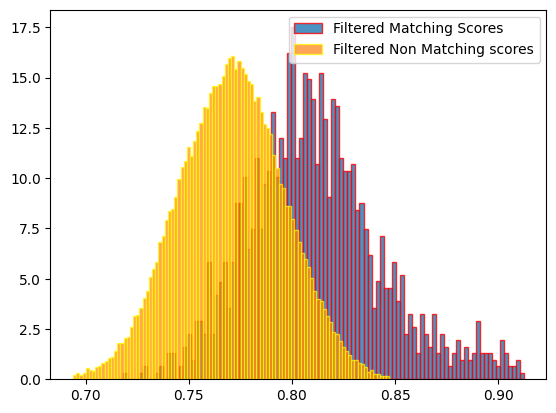

In [33]:
# plotting first histogram
plt.hist(filtered_matching, label='Filtered Matching Scores', bins=100, alpha=.8, edgecolor='red' ,density=True)
 
# plotting second histogram
plt.hist(filtered_non_matching, label='Filtered Non Matching scores', bins=100, alpha=0.7, edgecolor='yellow', density=True)
plt.legend()
 
# Showing the plot using plt.show()
plt.show()

In [34]:
# Setting the minimum and maximum cosine similarity scores for matched authors

min_score = min(filtered_matching)
max_score = max(filtered_matching)

In [35]:
min_score, max_score

(0.7180267572402954, 0.9124956727027892)

In [36]:
# Setting the minimum and maximum cosine similarity scores for non matched authors

min_score_non_matching = min(filtered_non_matching)
max_score_non_matching = max(filtered_non_matching)

In [37]:
min_score_non_matching, max_score_non_matching

(0.6938529014587402, 0.8471642732620239)

### Fine tuning

In [38]:
from sentence_transformers import InputExample, losses
from torch.utils.data import DataLoader

In the below section the LLM is fine tuned. There are two approaches adopted here. One will use the train_pairs/eval_pairs created earlier, in order to get a feel of the fit of the model when evaluated against an unseen dataset (the one we created using the train_test_split earlier). In the other I use the full_pairs dataset, where all of the data is used to then make predictions on the given dataset. 

In [39]:
train_examples = [
    InputExample(texts=[
        'query: ' + p.content1, 'query: ' + p.content2
    ], label=float(p.label)) for p in train_pairs # use train_pairs if evaluating on the created eval_pairs set
]

train_dataloader = DataLoader(train_examples,  batch_size=4)
train_loss = losses.ContrastiveLoss(model1)

batch_size = 4
n_train_steps = len(train_examples) // batch_size

model_params = {'train_objectives':[(train_dataloader, train_loss)],
                'epochs':3, 
                'optimizer_params': {'lr':1e-04}, 
                'weight_decay':1e-4, 
                'scheduler':'warmupcosine', 
                'warmup_steps':int(0.2 * n_train_steps),
               }

print('Fitting Model')
model1.fit(**model_params)

Fitting Model


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/127 [00:00<?, ?it/s]

Iteration:   0%|          | 0/127 [00:00<?, ?it/s]

Iteration:   0%|          | 0/127 [00:00<?, ?it/s]

### Getting emotions

The idea behind this section is to augment the characteristics that can be extracted from the given texts, which characteristics could be used to identify whether the two given pieces of text are by the same author or not. 
For this section a language model based on DistilRoBERTa-base created by Jochen Hartmann and published on Huggingface https://huggingface.co/j-hartmann/emotion-english-distilroberta-base/ will be used to extracted Ekman's 6 basic emotions, plus a neutral class:

- anger 🤬
- disgust 🤢
- fear 😨
- joy 😀
- neutral 😐
- sadness 😭
- surprise 😲

In [ ]:
import tensorflow as tf
print(tf.__version__) # check your version of tensorflow as the more recent version might not be compatible with the model. I managed to make it work using version 2.12.1

In [40]:
from transformers import pipeline

classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True,max_length=512, truncation=True,)

#### Emotions df for training set

In [41]:
emotion_cols = ['anger_1', 'disgust_1', 'fear_1', 'joy_1', 'neutral_1', 'sadness_1', 'surprise_1', 'anger_2', 'disgust_2', 'fear_2', 'joy_2', 'neutral_2', 'sadness_2', 'surprise_2']

emotions_df = pd.DataFrame(columns = emotion_cols)

In [42]:
for item in train_pairs:
    
    
    # Extracting the emotions
    emotion1 = classifier(item.content1)
    emotion2 = classifier(item.content2)
    
    # Extracting and appending scores
    scores1 = [item['score'] for item in emotion1[0]]
    scores2 = [item['score'] for item in emotion2[0]]
    row_scores = scores1+scores2
    
    # Append to existing emotions_df
    emotions_df.loc[len(emotions_df)] = row_scores    
    

In [43]:
emotions_df.head()

,anger_1,disgust_1,fear_1,joy_1,neutral_1,sadness_1,surprise_1,anger_2,disgust_2,fear_2,joy_2,neutral_2,sadness_2,surprise_2
0,0.031457,0.001329,0.030010,0.515784,0.097630,0.119717,0.204073,0.056074,0.001951,0.034739,0.150114,0.041628,0.462255,0.253238
1,0.139038,0.002100,0.059321,0.527743,0.063753,0.056108,0.151937,0.044143,0.001548,0.054011,0.565378,0.049525,0.088893,0.196502
2,0.031457,0.001329,0.030010,0.515784,0.097630,0.119717,0.204073,0.865456,0.000753,0.002677,0.013111,0.003037,0.103889,0.011077
3,0.056074,0.001951,0.034739,0.150114,0.041628,0.462255,0.253238,0.865456,0.000753,0.002677,0.013111,0.003037,0.103889,0.011077
4,0.139038,0.002100,0.059321,0.527743,0.063753,0.056108,0.151937,0.031457,0.001329,0.030010,0.515784,0.097630,0.119717,0.204073


#### Emotions dataframe for evaluation set

In [44]:
eval_emotions_df = pd.DataFrame(columns = emotion_cols)

In [45]:
for item in eval_pairs:
    
    
    # Extracting the emotions
    emotion1 = classifier(item.content1)
    emotion2 = classifier(item.content2)
    
    # Extracting and appending scores
    scores1 = [item['score'] for item in emotion1[0]]
    scores2 = [item['score'] for item in emotion2[0]]
    row_scores = scores1+scores2
    
    # Append to existing emotions_df
    eval_emotions_df.loc[len(eval_emotions_df)] = row_scores 

#### Emotions dataframe for full set

In [46]:
full_emotions_df = pd.DataFrame(columns = emotion_cols)

In [47]:
for item in full_pairs:
    
    
    # Extracting the emotions
    emotion1 = classifier(item.content1)
    emotion2 = classifier(item.content2)
    
    # Extracting and appending scores
    scores1 = [item['score'] for item in emotion1[0]]
    scores2 = [item['score'] for item in emotion2[0]]
    row_scores = scores1+scores2
    
    # Append to existing emotions_df
    full_emotions_df.loc[len(full_emotions_df)] = row_scores 

#### Getting cosine similarities for full set

In [48]:
corpus_full  = [e.content1 for e in full_pairs]
query_full = [q.content2 for q in full_pairs]
full_pairs_labels = [l.label for l in full_pairs]

Besides cosine similarity I have also calculated euclidean distance, correlation distance and manhattan distance

In [49]:
pred_scores_model1 = []
euclid_distances = []
corr_distances = []
manhattan_distances = []

# Getting cosine similarity scores from Model 1

for i in range(len(corpus_full)):
    
    corpus_embedding = model1.encode(corpus_full[i], convert_to_tensor=True, normalize_embeddings=True)
    query_embedding = model1.encode(query_full[i], convert_to_tensor=True, normalize_embeddings=True)
    cos_scores = util.cos_sim(query_embedding, corpus_embedding)[0]
    euclid_dist = pairwise_distances(corpus_embedding.cpu().reshape(1, -1) , query_embedding.cpu().reshape(1, -1), metric='euclidean' )[0][0]
    corr_dist = pairwise_distances(corpus_embedding.cpu().reshape(1, -1) , query_embedding.cpu().reshape(1, -1), metric='correlation' )[0][0]
    manhattan_dist = pairwise_distances(corpus_embedding.cpu().reshape(1, -1) , query_embedding.cpu().reshape(1, -1), metric='manhattan' )[0][0]
    
    pred_scores_model1.append(cos_scores.cpu().item())
    euclid_distances.append(euclid_dist)
    corr_distances.append(corr_dist)
    manhattan_distances.append(manhattan_dist)
    
print('Cosine Similarity Scores for Model 1 : done')

Cosine Similarity Scores for Model 1 : done


In [50]:
# Adding pairwise distances to the full_emotions dataframe

full_emotions_df['cossim'] = pred_scores_model1
full_emotions_df['euclid'] = euclid_distances
full_emotions_df['correlation'] = corr_distances
full_emotions_df['manhattan'] = manhattan_distances

#### Getting cosine similarities for training set

In [51]:
corpus_train  = [e.content1 for e in train_pairs]
query_train = [q.content2 for q in train_pairs]
true_labels_train = [l.label for l in train_pairs]

In [52]:
pred_scores_model1 = []
euclid_distances = []
corr_distances = []
manhattan_distances = []

# Getting cosine similarity scores from Model 1

for i in range(len(corpus_train)):
    
    corpus_embedding = model1.encode(corpus_train[i], convert_to_tensor=True, normalize_embeddings=True)
    query_embedding = model1.encode(query_train[i], convert_to_tensor=True, normalize_embeddings=True)
    cos_scores = util.cos_sim(query_embedding, corpus_embedding)[0]
    euclid_dist = pairwise_distances(corpus_embedding.cpu().reshape(1, -1) , query_embedding.cpu().reshape(1, -1), metric='euclidean' )[0][0]
    corr_dist = pairwise_distances(corpus_embedding.cpu().reshape(1, -1) , query_embedding.cpu().reshape(1, -1), metric='correlation' )[0][0]
    manhattan_dist = pairwise_distances(corpus_embedding.cpu().reshape(1, -1) , query_embedding.cpu().reshape(1, -1), metric='manhattan' )[0][0]
    
    pred_scores_model1.append(cos_scores.cpu().item()) 
    euclid_distances.append(euclid_dist)
    corr_distances.append(corr_dist)
    manhattan_distances.append(manhattan_dist)
    
print('Cosine Similarity Scores for Model 1 : done')

Cosine Similarity Scores for Model 1 : done


In [53]:
# Adding pairwise distances to training set

emotions_df['cossim'] = pred_scores_model1
emotions_df['euclid'] = euclid_distances
emotions_df['correlation'] = corr_distances
emotions_df['manhattan'] = manhattan_distances


#### Getting cosine similarities for evaluation set

In [54]:
corpus_eval  = [e.content1 for e in eval_pairs]
query_eval = [q.content2 for q in eval_pairs]
true_labels_eval = [l.label for l in eval_pairs]

In [55]:
eval_pred_scores_model1 = []
euclid_distances = []
corr_distances = []
manhattan_distances = []

# Getting cosine similarity scores from Model 1

for i in range(len(corpus_eval)):
    
    corpus_embedding = model1.encode(corpus_eval[i], convert_to_tensor=True, normalize_embeddings=True)
    query_embedding = model1.encode(query_eval[i], convert_to_tensor=True, normalize_embeddings=True)
    cos_scores = util.cos_sim(query_embedding, corpus_embedding)[0]
    euclid_dist = pairwise_distances(corpus_embedding.cpu().reshape(1, -1) , query_embedding.cpu().reshape(1, -1), metric='euclidean' )[0][0]
    corr_dist = pairwise_distances(corpus_embedding.cpu().reshape(1, -1) , query_embedding.cpu().reshape(1, -1), metric='correlation' )[0][0]
    manhattan_dist = pairwise_distances(corpus_embedding.cpu().reshape(1, -1) , query_embedding.cpu().reshape(1, -1), metric='manhattan' )[0][0]
        
    eval_pred_scores_model1.append(cos_scores.cpu().item())
    euclid_distances.append(euclid_dist)
    corr_distances.append(corr_dist)
    manhattan_distances.append(manhattan_dist)
        
print('Cosine Similarity Scores for Model 1 : done')

Cosine Similarity Scores for Model 1 : done


In [56]:
# Adding pairwise distances to evaluation set

eval_emotions_df['cossim'] = eval_pred_scores_model1
eval_emotions_df['euclid'] = euclid_distances
eval_emotions_df['correlation'] = corr_distances
eval_emotions_df['manhattan'] = manhattan_distances

### Preparing test set

In [57]:
test_df = test_df.join(test_texts_df.set_index('content_id'), on='content_id_1').rename({'content': 'content_1'}, axis=1)
test_df = test_df.join(test_texts_df.set_index('content_id'), on='content_id_2').rename({'content': 'content_2'}, axis=1)
test_df.head()

,prediction_id,content_id_1,content_id_2,content_1,content_2
0,0,195,186,"The road to glory is currently a quiet one, it seems. Welcome, Rahn'Keth. I'm your private ...",Service Corp International said the decision to withdraw its $2.9 billion hostile bid for Loewen...
1,1,111,145,"Well, Nigel is here... He's scared as hell and just sitting in his cage. His ears are HU...","To Lindsey: I don't expect advice, but if it needs to be given, I'd really like to hear..."
2,2,80,200,"Toronto stocks ended weaker in light trading on Thursday, swept lower by a downdraft in the oil ...","The Toronto Stock Exchange's key index ended higher on Wednesday, but the overall market finishe..."
3,3,71,87,Hope you dont have anything to do cos urlLink these games will keep you busy for a whil...,"sigh, i just got back from the doctors. They needled me. It still hurts. boo hoo. Yeah an..."
4,4,132,67,Interstate Bakeries Corp chairman Charles Sullivan said Thursday he backs analysts' earnings est...,"OEF &#151; Lance Cpl. Bryan P. Bertrand, 23, of Coos Bay, Oregon, was killed on..."


In [58]:
test_df['content_1'] = test_df.content_1.apply(preprocess_text)
test_df['content_2'] = test_df.content_2.apply(preprocess_text)

In [59]:
# Prepare test data
sentence_1_test = [i for i in test_df.content_1]
sentence_2_test = [i for i in test_df.content_2]

In [60]:
# Calculating pairwise distances

test_pred_scores_model1 = []
euclid_distances = []
corr_distances = []
manhattan_distances = []


for i in range(len(sentence_1_test)):
    
    corpus_embedding = model1.encode(sentence_1_test[i], convert_to_tensor=True, normalize_embeddings=True)
    query_embedding = model1.encode(sentence_2_test[i], convert_to_tensor=True, normalize_embeddings=True)
    cos_scores = util.cos_sim(query_embedding, corpus_embedding)[0]
    euclid_dist = pairwise_distances(corpus_embedding.cpu().reshape(1, -1) , query_embedding.cpu().reshape(1, -1), metric='euclidean' )[0][0]
    corr_dist = pairwise_distances(corpus_embedding.cpu().reshape(1, -1) , query_embedding.cpu().reshape(1, -1), metric='correlation' )[0][0]
    manhattan_dist = pairwise_distances(corpus_embedding.cpu().reshape(1, -1) , query_embedding.cpu().reshape(1, -1), metric='manhattan' )[0][0]
    
    test_pred_scores_model1.append(cos_scores.cpu().item())
    euclid_distances.append(euclid_dist)
    corr_distances.append(corr_dist)
    manhattan_distances.append(manhattan_dist)
    
print('Finished pairwise distance calculations')

Finished pairwise distance calculations


In [61]:
# Creating test_emotions dataframe

test_emotions_df = pd.DataFrame(columns = emotion_cols)

In [62]:
# Extracting emotion scores for test set

for s1,s2 in zip(sentence_1_test, sentence_2_test):
    
    # Extracting the emotions
    emotion1 = classifier(s1)
    emotion2 = classifier(s2)
    
    # Extracting and appending scores
    scores1 = [item['score'] for item in emotion1[0]]
    scores2 = [item['score'] for item in emotion2[0]]
    row_scores = scores1+scores2
    
    # Append to existing emotions_df
    test_emotions_df.loc[len(test_emotions_df)] = row_scores 

In [63]:
# Adding pairwise distances to test_emotions dataframe

test_emotions_df['cossim'] = test_pred_scores_model1
test_emotions_df['euclid'] = euclid_distances
test_emotions_df['correlation'] = corr_distances
test_emotions_df['manhattan'] = manhattan_distances

### Setting Model

In [64]:
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import  StratifiedKFold

In [65]:
def get_best_prob(y_val, y_pred):
    
    '''
    Takes in the true fold labels and fold predictions as parameters.
    Returns the best probability threshold that maximizes accuracy.
    '''
    
    best_threshold = None
    best_accuracy_score = -np.inf

    for threshold in np.linspace(0.01, 1.0, 99):
           
        preds = (y_pred > threshold).astype(int)
        score = accuracy_score(y_val, preds)
                
        if score > best_accuracy_score:
            best_accuracy_score = score
            best_threshold = threshold
        
    print(f"Best threshold for Accuracy found at probability: {best_threshold}")
    print(f'Accuracy : {best_accuracy_score}')
      
    return best_threshold

In [68]:
# Initialize and train the Models

cat_model = CatBoostClassifier(learning_rate=0.003722251144453506, max_depth=2, random_seed=SEED, l2_leaf_reg=1.5350412246186924 ,loss_function='Logloss', n_estimators=900)
rf_model = RandomForestClassifier(n_estimators=500, min_samples_leaf=9, n_jobs=-1, random_state=SEED)
lgbm_model = LGBMClassifier(max_depth=3, learning_rate=0.02, boosting='gbdt', verbose=-1)

# Initialize the StratifiedKFold
n_splits = 3  # Number of folds for k-fold cross-validation
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

# Lists to store the evaluation results for each fold
accuracy_scores = []

cat_pred = []
rf_pred = []
lgbm_pred = []

best_probs = []

models = [cat_model,  rf_model,  lgbm_model]
model_names = ['catboost',  'randomforest', 'lgbm']

X = full_emotions_df.copy() # here set X as either emotions_df (if predicting eval_pairs) or full_emotions_df (if predicting test set)
y = full_pairs_labels # here set y as true_labels_train if predicing eval_pairs or full_pairs_labels (if predicting test set)
X_test = test_emotions_df.copy() # here set as eval_emotions_df (if predicting eval_pairs) or test_emotions_df (if predicting test set)


for model, name in zip(models, model_names):
    
    print()
    print(f'Using {name}')
    print('-------------')
    
    # Perform Stratified KFold cross-validation
    for fold, (train_index, val_index) in enumerate(cv.split(X, y)):

        print(f'==> Processing fold {fold+1}')

        X_train, X_val = X.loc[train_index], X.loc[val_index]
        y_train, y_val = [y[i] for i in train_index], [y[i] for i in val_index]

        # Train the model on the training fold
        if name == 'catboost':
            model.fit(X_train, y_train, verbose=0, eval_set=(X_val, y_val), early_stopping_rounds=100)
            
        else:
            model.fit(X_train, y_train)
        

        # Make predictions on the validation fold
        y_pred = model.predict_proba(X_val)[:,1]
        
        # Make predictions on the test_set
        test_preds = model.predict_proba(X_test)[:,1]
        
        
        if name == 'catboost':
            cat_pred.append(test_preds)
        elif name == 'randomforest':
            rf_pred.append(test_preds)
        elif name == 'lgbm':
            lgbm_pred.append(test_preds)

        # Choosing the best probability threshold
        best_prob = get_best_prob(y_val, y_pred)
        fold_preds = (y_pred > best_prob).astype(int)
        best_probs.append(best_prob)
        
        # Calculate accuracy for this fold and store it
        accuracy = accuracy_score(y_val, fold_preds)
        
        accuracy_scores.append(accuracy)

# Calculate the average accuracy across all folds
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print()
print("Average Accuracy:", average_accuracy)



Using catboost

-------------

==> Processing fold 1

Best threshold for Accuracy found at probability: 0.1413265306122449

Accuracy : 0.8949771689497716

==> Processing fold 2

Best threshold for Accuracy found at probability: 0.6868367346938775

Accuracy : 0.9178082191780822

==> Processing fold 3

Best threshold for Accuracy found at probability: 0.6363265306122449

Accuracy : 0.8899082568807339



Using randomforest

-------------

==> Processing fold 1

Best threshold for Accuracy found at probability: 0.12112244897959183

Accuracy : 0.8995433789954338

==> Processing fold 2

Best threshold for Accuracy found at probability: 0.4746938775510204

Accuracy : 0.91324200913242

==> Processing fold 3

Best threshold for Accuracy found at probability: 0.5757142857142857

Accuracy : 0.8899082568807339



Using lgbm

-------------

==> Processing fold 1

Best threshold for Accuracy found at probability: 0.2423469387755102

Accuracy : 0.8949771689497716

==> Processing fold 2

Best thresh

### Predictions for test set

In [ ]:
cat_preds = np.mean(cat_pred,axis=0)
rf_preds =  np.mean(rf_pred,axis=0)
lgbm_preds = np.mean(lgbm_pred,axis=0)
comb_preds = np.mean([cat_preds,  rf_preds, lgbm_preds],axis=0)

### Prediction and submission

In [70]:
final_preds_df = sample_submission_df.copy()

In [75]:
final_preds_df['label'] = np.round(comb_preds,0).astype(int)
final_preds_df.to_csv('tantus_submission.csv', index=False)
final_preds_df.head()

,prediction_id,label
0,0,0
1,1,1
2,2,1
3,3,0
4,4,0
